# New CEA Fit Notebook - 12/15/2023

# After 12/15 HRC thermal working group meeting, the model will be refit with the following new conditions:
1: freeze ACIS DPA power parameters to those in DPA model, and only fit DPA multiplier and bias<br>
2: zero out power input from HRC-I and HRC-S power supplies, and do not fit them. Only fit shield power, and let it carry power input from detector HVPS<br>
3: remove 105 deg pitch bin<br>

# Start with original CEA model cea_spec.json

In [1]:
from os.path import expanduser
import sys
import numpy as np
import json
import xija
from Ska.engarchive import fetch_eng as fetch
from cxotime import CxoTime
import re
import pandas as pd

In [2]:
import xijafit
xija.__version__

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find xpaget on your PATH'


'4.31.0'

In [3]:
import kadi
from kadi.commands import states
from kadi.commands.states import reduce_states
from urllib.request import urlopen
import matplotlib.pyplot as plt
from matplotlib import cm, colors, colorbar
from matplotlib.collections import LineCollection
from matplotlib.dates import (YearLocator, MonthLocator, DayLocator,
                              HourLocator, MinuteLocator, SecondLocator,
                              DateFormatter, date2num)
from matplotlib.ticker import FixedLocator, FixedFormatter
from datetime import datetime

In [4]:
from xijafit.dashboard import make_dashboard, dashboard
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/var/folders/2v/8rh_hsj96d700rq88yst31xw0000gn/T/ipykernel_46187/3476023983.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [5]:

def CtoF(cs):
    try:
        return np.array([c * 1.8 + 32 for c in cs])
    except TypeError:
        return cs * 1.8 + 32


def FtoC(cs):
    try:
        return np.array([(c - 32) / 1.8 for c in cs])
    except TypeError:
        return (cs - 32) / 1.8

    
def set_param(model, param, value):
    """Set parameter to specific value.

    Args:
        model: Xija model object
        param: Specific parameter to set
        value: parameter value
        
    """
    found = False
    for par in model.pars:
        if param in par.full_name:
            par['val'] = value
            found = True
    if not found:
        print(('Parameter: {} not found'.format(param)))
            
    
def get_npnt_state_data(tstart, tstop):
    """ Get states where 'vid_board', 'clocking', 'fep_count', 'pcad_mode' are constant.
    Args:
        tstart (int, float, string): Start time, using Ska time epoch 
        tstop (int, float, string): Stop time, using Ska time epoch
        
    Returns:
        (numpy.ndarray): state data
    """

    keys = ['pitch', 'off_nom_roll', 'ccd_count', 'fep_count', 'clocking', 'vid_board', 'pcad_mode', 'simpos'] 
    state_data = states.get_states(tstart, tstop, state_keys=keys, merge_identical=True)
      
    # relying on 'pcad_mode' to ensure attitude does not change significantly within a dwell
    state_data = states.reduce_states(state_data, ['pcad_mode'], all_keys=True, merge_identical=True)

    return np.array(state_data[state_data['pcad_mode'] == 'NPNT'])


def plot_pitch_dwells(msid, segments, segmentcolors, plist, telem_bounds, maxsec=80000, err=False, savefigfilename=False, ybounds=None, extra_text='', alternate_colorscale_title=None):
    """ Plot temperature segments binned by pitch
    Args:
        msid (string): msid name
        segemnts (dict): dictionary of temperature segments, where each key corresponds to a pitch bin
        segmentcolors (dict): colors for each line, structure matches segments object
        plist (tuple, list, numpy.ndarray): bounding pitch values for all bins (e.g. [45, 75, 90, 120, 180]) 
        telem_bounds (list, tuple): min and max temperatures to set range for colorbar
        maxsec (int, float): max duration in seconds for x axis
        err (bool): Boolean indicating whether or not the segments represent errors, if False it assumes they are observed or modeled temperatures
        safefigfilename (string, bool): Filename to save the figure to, if False figure is not saved to a file
        ybounds (list, tuple, bool): Y axis bounds for all subplots
        extra_text (string): Additional text to add to the title
        
    Returns:
        (matplotlib.figure.Figure): Matplotib figure object
    """
        
    def plotcollection(segmentset, segmentcolor, ax):
        sel = np.zeros(len(segmentset), dtype=int)
        lin = LineCollection(segmentset, pickradius=15, color=segmentcolor, linewidth=1, alpha=0.8)
        lin.set_picker(True)
        ax.add_collection(lin)
        ax.autoscale()
        ax.set_xbound(0, maxsec)
        ax.set_xticks(xticks)
        
        if ybounds:
            ax.set_ybound(ybounds)
            ax.set_ylim(ybounds)
            
        return lin, sel

    def get_annot_text(meta):
        basestr = 'OBSID: {}\nStart: {}\nEnd: {}\nStart Pitch: {}'
        retstr = basestr.format(meta['obsid'], meta['datestart'], meta['datestop'], round(meta['pitch'], 2))
        return retstr

    num = len(segments)
    ystart = {key: value for (key, value) in zip(segments.keys(), np.linspace(.12, .88, num))}
    yheight = (.82 - .12)/(num)
    prange = {key: '{}-{}'.format(value[0], value[1]) for (key, value) in 
              zip(segments.keys(), [(int(plist[n]), int(plist[n+1])) for n in range(len(plist) - 1)])}

    xticks = np.arange(0., maxsec, 10000)

    fig = plt.figure(figsize=(10, 15))

    axs = []
    lines = []
    selected = []
    for n in ystart.keys():
        axs.append(fig.add_axes([0.1, ystart[n], 0.8, yheight]))

        lin, sel = plotcollection(segments[n], segmentcolors[n], axs[n])
        lines.append(lin)
        selected.append(sel)

        axs[-1].set_ylabel('{}'.format(prange[n]), fontsize=12)
        axs[n].tick_params(axis='y', size=12)

        if n > 0:
            axs[n].set_xticklabels('')
        else:
            axs[n].set_xticklabels([round(int(val)/1000., 2) for val in axs[n].get_xticks()], fontsize=14)
        axs[n].grid(True)

    axs[0].set_xlabel('Time (Kiloseconds)', fontsize=14)
    
    if err == False:
        axs[-1].set_title(f'{msid.upper()} Temperature Trends (Dwells > 1Hr){extra_text}', fontsize=16)
    else:
        axs[-1].set_title(f'{msid.upper()} Error Trends (Dwells > 1Hr){extra_text}', fontsize=16)
        
    bounds = np.linspace(np.floor(telem_bounds[0]), np.ceil(telem_bounds[1]), 25)
    norm = colors.BoundaryNorm(bounds, cm.BrBG.N)
    cbax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
    cb = colorbar.ColorbarBase(cbax, cmap=cm.viridis, spacing='proportional', norm=norm, orientation="horizontal")
    
    if alternate_colorscale_title:
        _ = cb.ax.set_xlabel(alternate_colorscale_title, fontsize=14)
    else:
        _ = cb.ax.set_xlabel('Dwell Start Temperature (Deg F)', fontsize=14)
    _ = cb.ax.tick_params(axis='x', labelsize=14)

    plt.show()

    if savefigfilename:
        fig.savefig(savefigfilename)
        
    return fig


def bin_data_by_pitch(state_data, plist, times, telem, error, color_stat='start'):
    """ Bin telemetry and model error data by dwell pitch
    
    Args:
        (numpy.ndarray): state data
        plist (tuple, list, numpy.ndarray): bounding pitch values for all bins (e.g. [45, 75, 90, 120, 180]) 
        times (numpy.ndarray): times corresponding to telemetry and error arrays
        telem (numpy.ndarray): telemetry to separate into dwell pitch bins
        error (numpy.ndarray): model error values to separate into dwell pitch bins

    Returns:
        (matplotlib.figure.Figure): Matplotib figure object
        
    Note:
        Telemetry and error are binned in the same loop since their arrays are expected to align and it is faster to 
        work on both together than to call this function separately twice (since often both quantities are needed).
    """
    
    pind = np.digitize(state_data['pitch'], bins=plist)-1

    # pinds could be simply range(len(plist) - 1), except sometimes some bins won't 
    # have any data, which will cause problems. Instead determine which bins actually
    # have data so we only use those.
    pinds = list(set(pind))
    pinds.sort()


    telem_segments = dict([(n, []) for n in pinds])
    metadata = dict([(n, []) for n in pinds])
    err_segments = dict([(n, []) for n in pinds])
    segmentcolors = dict([(n, []) for n in pinds])
    telem_bounds = (np.min(telem), np.max(telem))
    norm = colors.Normalize(vmin=telem_bounds[0], vmax=telem_bounds[1])

    for num in pinds:
        for s in state_data[pind==num]:
            tind = (times >= s['tstart']) & (times < s['tstop'])
            if any(tind) & ((s['tstop'] - s['tstart']) > 3600):
                reltimes = times[tind] - times[tind][0]
                temps = telem[tind]

                metadata[num].append(s)
                telem_segments[num].append(list(zip(reltimes, temps)))

                err = error[tind]
                err_segments[num].append(list(zip(reltimes, err)))
                
                if 'stop' in color_stat.lower():
                    temp_color_calc = temps[-1]
                elif 'median' in color_stat.lower():
                    temp_color_calc = np.median(temps)
                elif 'mean' in color_stat.lower():
                    temp_color_calc = np.mean(temps)
                else:
                    temp_color_calc = temps[0]
                
                segmentcolors[num].append(cm.viridis(norm(temps[0])))

        metadata[num] = np.array(metadata[num], dtype=s.dtype)

    return metadata, telem_segments, err_segments, segmentcolors, telem_bounds


def smooth_segments(telem_segments, order=1):
    """ Smooth each temperature segment
    
    This makes it easier to see individual telemetry trends by smoothing out the data for each dwell by 
    fitting a polynomal curve to each segment, and returning the recalculated temperature output from each fit.
    
    Args:
        telem_segments (dict): dictionary of temperature segments, where each key corresponds to a pitch bin
        order (int): Order of polynomial fit used to 
        
    Returns:
        (dict): Smoothed temperature segment
    """
    
    
    smoothed_telem_segments = {}
    for key, pitch_group in telem_segments.items():
        smoothed_pitch_group = []
        for single_dwell in pitch_group:
            t, temp = list(zip(*single_dwell))
            param = np.polyfit(t, temp, order)
            smoothed_temps = np.polyval(param, t)
            smoothed_pitch_group.append(list(zip(t, smoothed_temps)))
        smoothed_telem_segments[key] = smoothed_pitch_group       
    return smoothed_telem_segments



def plot_model_data(pred, tel, p, r, t, dpa_power, simz, boolean_data):
    """ Plot model information
    
    This function is intended to serve as a modifiable starting point to plot data aligned along the time axis.

    Args:
        pred (numpy.ndarray): Temperature predictions
        tel (numpy.ndarray): Telemetry values
        p (numpy.ndarray): Pitch
        r (numpy.ndarray): Roll
        t (numpy.ndarray): Time
        dpa_power (numpy.ndarray): Dpa Power
        boolean_data (dict): Dictionary of boolean values, where each value matches the array quantities above (e.g. t)

    Returns:
        None

    """
    
   
    def make_boolean_plot(position, name, times, data, share_ax, parent_fig):
        new_ax = parent_fig.add_axes(position, sharex=share_ax)
        new_ax.plot(times, data[name], color=[.5, .5, .5], linewidth=0.5)
        new_ax.set_xlim(times[0], times[-1])
        new_ax.set_ylabel(name, rotation=45, ha='right')
        new_ax.set_yticks([0, 1])
        new_ax.set_yticklabels(['Off', 'On'])
        new_ax.set_ylim(-.2, 1.2)
        new_ax.grid(False)
        new_ax.tick_params(bottom=False, labelbottom=False)
        new_ax.spines['top'].set_visible(False)
        new_ax.spines['right'].set_visible(False)
        new_ax.spines['bottom'].set_visible(False)
        return new_ax
    
    
    def generate_single_data_plot(position, label, times, data, share_ax, parent_fig, ylim=None):
        new_ax = parent_fig.add_axes(position, sharex=share_ax)
        new_ax.plot(times, data, color=[.5, .5, .5], linewidth=0.5)
        new_ax.set_xlim(times[0], times[-1])
        if ylim:
            new_ax.set_ylim(ylim)
        new_ax.grid(True, which='major', axis='both', color='#eeeeee')
        new_ax.set_ylabel(label)
        new_ax.spines['top'].set_visible(False)
        new_ax.spines['right'].set_visible(False)
        new_ax.spines['bottom'].set_visible(False)
        new_ax.tick_params(bottom=False, labelbottom=False)
        return new_ax

    start = t[0]
    stop = t[-1]
    
    tickstart = CxoTime(CxoTime(start).date[0:8] + ':00:00:00').secs
    numdays = int(CxoTime(stop).date[5:8]) - int(CxoTime(start).date[5:8])
    increments = np.ceil(numdays/8)
    xticks = np.linspace(start, stop, 8)
    xticklabels = [CxoTime(tick).date[:8] for tick in xticks]

    fig = plt.figure(figsize=[14,14], facecolor='white')
    
    
    ax1 = fig.add_axes([0.10, 0.03, 0.8, 0.01])
    ax1.set_xlim(t[0], t[-1])
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticklabels, color='black')
    ax1.set_yticklabels('')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.tick_params(left=False)
    
    ax2 = fig.add_axes([0.10, 0.75, 0.8, 0.20], sharex=ax1)
    ax2.plot(t, tel, color='blue', linewidth=0.5)
    ax2.plot(t, pred, color='red', linewidth=0.5) #, marker='.', markersize=1)
    ax2.set_xlim(t[0], t[-1])
    ax2.grid(True, color='#eeeeee')
    ax2.set_ylabel('CEA Telemetry (Blue) and Model (Red)')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.tick_params(bottom=False, labelbottom=False)

    ax3 = generate_single_data_plot([0.10, 0.64, 0.8, 0.1], 'Error', t, tel - pred, ax1, fig)
    ax4 = generate_single_data_plot([0.10, 0.53, 0.8, 0.1], 'Pitch', t, p, ax1, fig)
    ax5 = generate_single_data_plot([0.10, 0.46, 0.8, 0.06], 'Roll', t, roll, ax1, fig, ylim=(-25, 25))
    ax6 = generate_single_data_plot([0.10, 0.39, 0.8, 0.06], 'simz', t, simz, ax1, fig)
    ax7 = generate_single_data_plot([0.10, 0.32, 0.8, 0.06], 'DPA Power', t, dpa_power, ax1, fig)
    
    ax8 = make_boolean_plot([0.10, 0.28, 0.8, 0.025], 'radmon', t, boolean_data, ax1, fig)

    ax9 = make_boolean_plot([0.10, 0.25, 0.8, 0.02], '2ps5aon_on', t, boolean_data, ax1, fig)
    ax10 = make_boolean_plot([0.10, 0.22, 0.8, 0.02], '2imonst_on', t, boolean_data, ax1, fig)
    ax11 = make_boolean_plot([0.10, 0.19, 0.8, 0.02], '2sponst_on', t, boolean_data, ax1, fig)
    ax12 = make_boolean_plot([0.10, 0.16, 0.8, 0.02], '2s2onst_on', t, boolean_data, ax1, fig)
    ax13 = make_boolean_plot([0.10, 0.13, 0.8, 0.02], '215pcast_off', t, boolean_data, ax1, fig)
    ax14 = make_boolean_plot([0.10, 0.10, 0.8, 0.02], '224pcast_off', t, boolean_data, ax1, fig)  
#     ax15 = make_boolean_plot([0.10, 0.07, 0.8, 0.02], '215pcastb_off', t, boolean_data, ax1, fig)
#     ax16 = make_boolean_plot([0.10, 0.04, 0.8, 0.02], '224pcastb_off', t, boolean_data, ax1, fig)  
    
    ax2.set_title('HRC CEA Model Data', fontsize=20)

Fetching msid: 2ceahvpt over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: sim_z over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: pitch over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: roll over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: aoeclips over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: 1dahtbon over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Getting kadi commanded states over 2022:240:00:02:46.816 to 2023:342:23:51:34.816
Fetching msid: dp_dpa_power over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: 2ps5aon over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: 2ps5bon over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: 2imonst over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: 2sponst over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: 2s2onst over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: 22

<IPython.core.display.Javascript object>


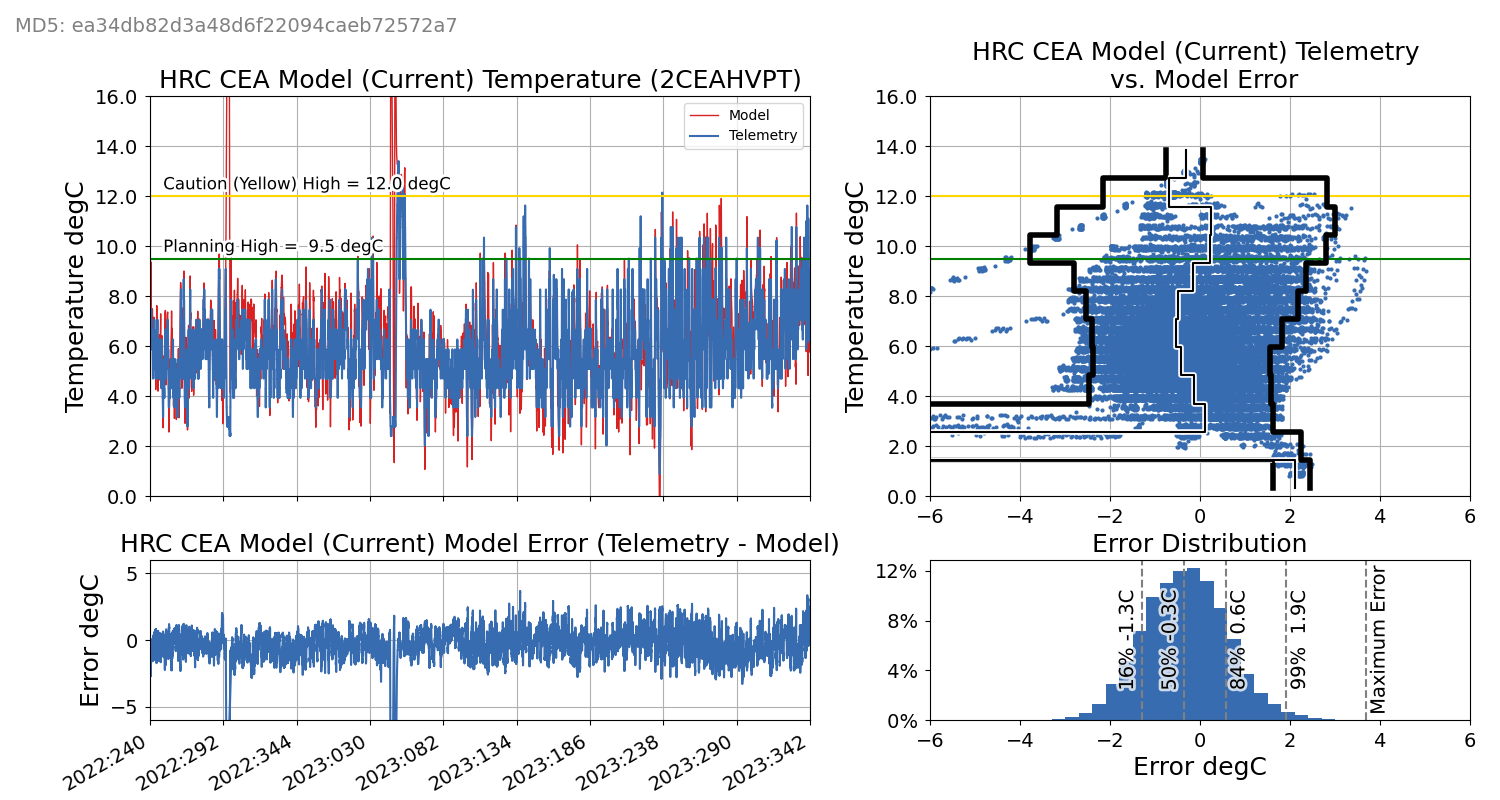

In [6]:
import xija
from xijafit.dashboard import make_dashboard
init = {
    'cea0': 10.0, 
    'cea1': 10.0, 
    }
tstart = '2022:240:00:00:00'
tstop = '2023:343:00:00:00'
model_spec_filename = '/Users/patnaude/ska/data/chandra_models/chandra_models/xija/hrc/cea_spec.json'
model = make_dashboard(model_spec_filename, 
                       tstart, 
                       tstop, 
                       init=init, 
                       modelname='HRC CEA Model (Current)', 
                       msid='2ceahvpt', 
                       bin_size=1, 
                       errorplotlimits=(-6, 6),
                       yplotlimits=(0, 15))

msid = '2ceahvpt'
msiddata = model.get_comp(msid)
prediction = msiddata.mvals.astype(np.float64) # Always do math with 64 bit resolution
times = msiddata.times.astype(np.float64)
telem = msiddata.dvals.astype(np.float64)
error = telem - prediction

# Initialize filtering array to True (keep all points)
# This isn't really necessary here, but I often use this pattern to remove data not relevant to the evaluation of the model
keep = np.zeros(len(telem)) < 1 

# Local functions

## Look at pitch bins

<IPython.core.display.Javascript object>


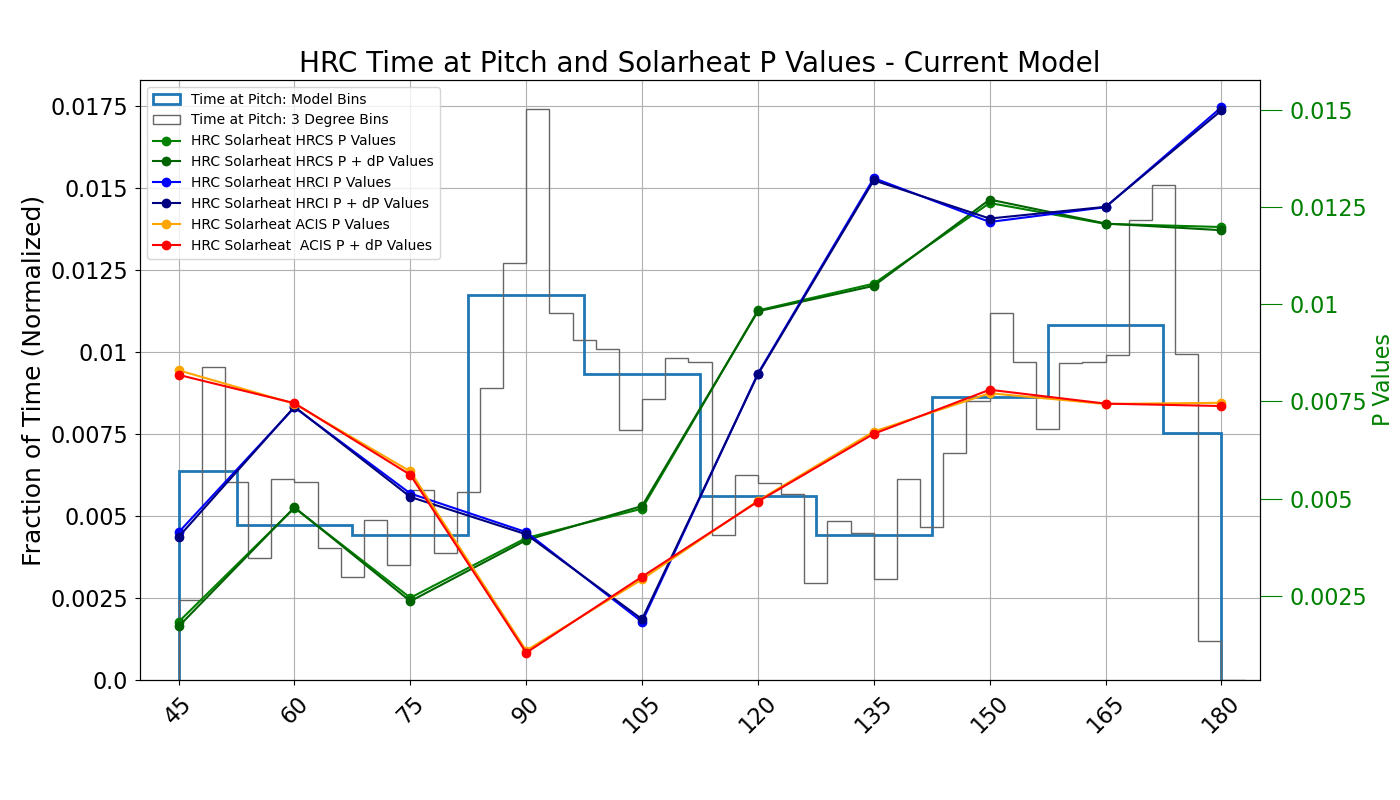

/var/folders/2v/8rh_hsj96d700rq88yst31xw0000gn/T/ipykernel_46187/26463575.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize=16)
/var/folders/2v/8rh_hsj96d700rq88yst31xw0000gn/T/ipykernel_46187/26463575.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax.get_yticks(), fontsize=16)


In [7]:
r = re.compile('solarheat__cea0__P_hrcs_(\d+).*')
p = [(r.findall(d['full_name'])[0], d['val']) for d in model.pars if r.findall(d['full_name'])]
pa_hrcs = np.array(p, dtype=[('pitch', 'i8'), ('val', 'float64')])

r = re.compile('solarheat__cea0__P_hrci_(\d+).*')
p = [(r.findall(d['full_name'])[0], d['val']) for d in model.pars if r.findall(d['full_name'])]
pa_hrci = np.array(p, dtype=[('pitch', 'i8'), ('val', 'float64')])

r = re.compile('solarheat__cea0__P_acis_(\d+).*')
p = [(r.findall(d['full_name'])[0], d['val']) for d in model.pars if r.findall(d['full_name'])]
pa_acis = np.array(p, dtype=[('pitch', 'i8'), ('val', 'float64')])

r = re.compile('solarheat__cea0__dP_(\d+).*')
dp = [(r.findall(d['full_name'])[0], d['val']) for d in model.pars if r.findall(d['full_name'])]
dpa = np.interp(pa_hrcs['pitch'], list(zip(*dp))[0], list(zip(*dp))[1])
dpa = np.array(list(zip(pa_hrcs['pitch'], dpa)), dtype=[('pitch', 'i8'), ('val', 'float64')])

plist = list(dpa['pitch'][:-1] + np.diff(dpa['pitch']) / 2)
plist.insert(0, dpa['pitch'][0])
plist.append(dpa['pitch'][-1])

pitch = fetch.Msid('pitch', tstart, tstop, stat='5min')
pitch = pitch.vals

fig = plt.figure(figsize=(14, 8))
ax = fig.add_axes([0.1, 0.15, 0.8, 0.75])
hist1 = ax.hist(pitch, bins=plist, density=True, linewidth=2, histtype='step', label='Time at Pitch: Model Bins')
hist2 = ax.hist(pitch, bins=np.arange(45, 185, 3), density=True, linewidth=1, color=[.4, .4, .4], histtype='step',
        label='Time at Pitch: 3 Degree Bins')
ax = plt.gca()
ax.set_xticks(dpa['pitch'])
ax.set_xticklabels(ax.get_xticks(), fontsize=16, rotation=45, ha='center')
ax.set_yticklabels(ax.get_yticks(), fontsize=16)
ax.set_title('HRC Time at Pitch and Solarheat P Values - Current Model', fontsize=20)
ax.set_ylabel('Fraction of Time (Normalized)', fontsize=18)
ax.set_xlim(40, 185)
ax.grid(True)

ax2 = ax.twinx()
ln1 = ax2.plot(pa_hrcs['pitch'], pa_hrcs['val'], color='green', marker='o', label='HRC Solarheat HRCS P Values')
ln2 = ax2.plot(pa_hrcs['pitch'], pa_hrcs['val'] + dpa['val'], color='#006400', marker='o', label='HRC Solarheat HRCS P + dP Values')

ln3 = ax2.plot(pa_hrci['pitch'], pa_hrci['val'], color='blue', marker='o', label='HRC Solarheat HRCI P Values')
ln4 = ax2.plot(pa_hrci['pitch'], pa_hrci['val'] + dpa['val'], color='navy', marker='o', label='HRC Solarheat HRCI P + dP Values')

ln5 = ax2.plot(pa_acis['pitch'], pa_acis['val'], color='orange', marker='o', label='HRC Solarheat ACIS P Values')
ln6 = ax2.plot(pa_acis['pitch'], pa_acis['val'] + dpa['val'], color='red', marker='o', label='HRC Solarheat  ACIS P + dP Values')


ax2.set_xlim(40, 185)
ax2.set_ylabel('P Values', color='green', fontsize=16)
ax2.set_yticklabels(ax.get_yticks(), fontsize=16)
ax2.tick_params('y', colors='green', size=16)

lns = hist1[-1] + hist2[-1] + ln1 + ln2 + ln3 + ln4 + ln5 + ln6 
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=2)

plt.show()

fig.savefig('HRC_Time_at_Pitch_with_Solarheat_Model_Current.png')

# Now start doing refit

In [8]:
class XijaFitPatched(xijafit.XijaFit):

    def thaw_solarheat_p(self, msid, instrument):
        """Thaw all solarheat "P" parameters.
        """
        p = f'.*solarheat__{msid.lower()}__P_{instrument.lower()}_\d+'
        found = False
        for par in self.model.pars:
            if re.match(p, par.full_name):
                par['frozen'] = False
                found = True
        if not found:
            print('Solarheat "P" parameters not found')

    def thaw_solarheat_dp(self, msid):
        """Thaw all solarheat "dP" parameters.
        """
        p = '.*solarheat__{}__dP_\d+'.format(msid.lower())
        found = False
        for par in self.model.pars:
            if re.match(p, par.full_name):
                par['frozen'] = False
                found = True
        if not found:
            print('Solarheat "dP" parameters not found')

    def thaw_dpa_power(self):
        p = f'dpa_power__pow_....'
        for par in self.model.pars:
            if re.match(p, par.full_name):
                par['frozen'] = False


In [9]:
#-----------------------------------------------------------------------------
# Set up model

tstart = '2022:240:00:00:00'
tstop = '2023:345:00:00:00'
# model_spec_filename = '/Users/patnaude/ska/data/chandra_models/chandra_models/xija/hrc/cea_spec.json'
# use a local copy of cea_spec.json as I edited the range on the solar heating parameters
model_spec_filename='./cea_spec_local.json'
newmodel = XijaFitPatched(model_spec_filename, start=tstart, stop=tstop, set_data_exprs=None, quiet=True, name='2ceahvpt')


stars = '*'*80
n = 0

Fetching msid: 2ceahvpt over 2022:239:23:35:26.816 to 2023:345:00:19:50.816
Fetching msid: sim_z over 2022:239:23:35:26.816 to 2023:345:00:19:50.816
Fetching msid: pitch over 2022:239:23:35:26.816 to 2023:345:00:19:50.816
Fetching msid: roll over 2022:239:23:35:26.816 to 2023:345:00:19:50.816
Fetching msid: aoeclips over 2022:239:23:35:26.816 to 2023:345:00:19:50.816
Fetching msid: 1dahtbon over 2022:239:23:35:26.816 to 2023:345:00:19:50.816
Getting kadi commanded states over 2022:240:00:02:46.816 to 2023:344:23:52:30.816
Fetching msid: dp_dpa_power over 2022:239:23:35:26.816 to 2023:345:00:19:50.816
Fetching msid: 2ps5aon over 2022:239:23:35:26.816 to 2023:345:00:19:50.816
Fetching msid: 2ps5bon over 2022:239:23:35:26.816 to 2023:345:00:19:50.816
Fetching msid: 2imonst over 2022:239:23:35:26.816 to 2023:345:00:19:50.816
Fetching msid: 2sponst over 2022:239:23:35:26.816 to 2023:345:00:19:50.816
Fetching msid: 2s2onst over 2022:239:23:35:26.816 to 2023:345:00:19:50.816
Fetching msid: 22

In [10]:
newmodel.freeze_all()

In [40]:
newmodel.thaw_solarheat_p('cea0', 'acis')
newmodel.thaw_solarheat_p('cea0', 'hrci')
newmodel.thaw_solarheat_p('cea0', 'hrcs')
newmodel.thaw_param(u'solarheat__cea0__ampl')
newmodel.thaw_param(u'solarheat_off_nom_roll__cea0__P_plus_y')
newmodel.thaw_param(u'solarheat_off_nom_roll__cea0__P_minus_y')

newmodel.thaw_param(u'heatsink__cea0__P')
newmodel.thaw_param(u'heatsink__cea0__tau')
newmodel.thaw_param(u'heatsink__cea0__T_ref')

newmodel.thaw_param(u'heatsink__cea1__P')
newmodel.thaw_param(u'heatsink__cea1__tau')
newmodel.thaw_param(u'heatsink__cea1__T_ref')

newmodel.thaw_param(u'coupling__2ceahvpt__cea0__tau')
newmodel.thaw_param(u'coupling__cea0__cea1__tau') 
newmodel.thaw_param(u'dpa_power__mult')
newmodel.thaw_param(u'dpa_power__bias')


newmodel.thaw_param(u'2ps5aon_on__P')

# leave the next 3 parameters frozen - roll power into shield PS
# also, don't fit side B
#newmodel.thaw_param(u'2ps5bon_on__P')

newmodel.thaw_param(u'2imonst_on__P')
newmodel.thaw_param(u'2sponst_on__P')
newmodel.thaw_param(u'2s2onst_on__P')

newmodel.thaw_param(u'224pcast_off__P')
newmodel.thaw_param(u'215pcast_off__P')

# update the range on some parameters

In [41]:
newmodel.set_range('solarheat_off_nom_roll__cea0__P_plus_y', -50., 50.)
newmodel.set_range('solarheat_off_nom_roll__cea0__P_minus_y', -50., 50.)

In [42]:
newmodel.fit(method='moncar')


Dataset               = 1
Method                = moncar
Statistic             = xijastat
Initial fit statistic = 1.25021e+07
Final fit statistic   = 2.09856e+06 at function evaluation 101283
Data points           = 1
Degrees of freedom    = -48
Change in statistic   = 1.04035e+07
   xijamod.coupling__2ceahvpt__cea0__tau   72.4999     
   xijamod.coupling__cea0__cea1__tau   2.35849     
   xijamod.hrc_is_acis_simz_solarheat__cea0__P_hrcs_45   -3.13447    
   xijamod.hrc_is_acis_simz_solarheat__cea0__P_hrcs_60   -4.17123    
   xijamod.hrc_is_acis_simz_solarheat__cea0__P_hrcs_75   -1.375      
   xijamod.hrc_is_acis_simz_solarheat__cea0__P_hrcs_90   -4.79193    
   xijamod.hrc_is_acis_simz_solarheat__cea0__P_hrcs_105   0.475403    
   xijamod.hrc_is_acis_simz_solarheat__cea0__P_hrcs_120   2.35318     
   xijamod.hrc_is_acis_simz_solarheat__cea0__P_hrcs_135   3.95602     
   xijamod.hrc_is_acis_simz_solarheat__cea0__P_hrcs_150   7.02292     
   xijamod.hrc_is_acis_simz_solarheat__cea0__P

In [43]:
from xijafit import *
fitstats = [snapshot['fit_stat']/(DateTime(snapshot['tstop']).secs - DateTime(snapshot['tstart']).secs)
            for snapshot in newmodel.snapshots]

In [44]:
newmodel.freeze_all()

# now do the dP's

In [45]:
#-----------------------------------------------------------------------------
# Long term Dp parameter fit only

n = n + 1
print('{}\nStep {}\n{}'.format(stars, n, stars))

newmodel.freeze_all()

newmodel.thaw_solarheat_dp('cea0')
newmodel.fit(method='moncar')

********************************************************************************
Step 1
********************************************************************************
Dataset               = 1
Method                = moncar
Statistic             = xijastat
Initial fit statistic = 2.09856e+06
Final fit statistic   = 2.09409e+06 at function evaluation 5152
Data points           = 1
Degrees of freedom    = -9
Change in statistic   = 4474.3
   xijamod.hrc_is_acis_simz_solarheat__cea0__dP_45   -0.0130596  
   xijamod.hrc_is_acis_simz_solarheat__cea0__dP_60   -0.00104606 
   xijamod.hrc_is_acis_simz_solarheat__cea0__dP_75   -0.00493077 
   xijamod.hrc_is_acis_simz_solarheat__cea0__dP_90   0.00131048  
   xijamod.hrc_is_acis_simz_solarheat__cea0__dP_105   -0.00101268 
   xijamod.hrc_is_acis_simz_solarheat__cea0__dP_120   0.00935997  
   xijamod.hrc_is_acis_simz_solarheat__cea0__dP_135   -0.0085068  
   xijamod.hrc_is_acis_simz_solarheat__cea0__dP_150   0.011906    
   xijamod.hrc_is_acis_si

In [46]:
newmodel.write_spec_file('./cea_spec_new_fit_acis_hrc_dp_15dec23.json')

Fetching msid: 2ceahvpt over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: sim_z over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: pitch over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: roll over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: aoeclips over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: 1dahtbon over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Getting kadi commanded states over 2022:240:00:02:46.816 to 2023:342:23:51:34.816
Fetching msid: dp_dpa_power over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: 2ps5aon over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: 2ps5bon over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: 2imonst over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: 2sponst over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: 2s2onst over 2022:239:23:35:26.816 to 2023:343:00:18:54.816
Fetching msid: 22

<IPython.core.display.Javascript object>


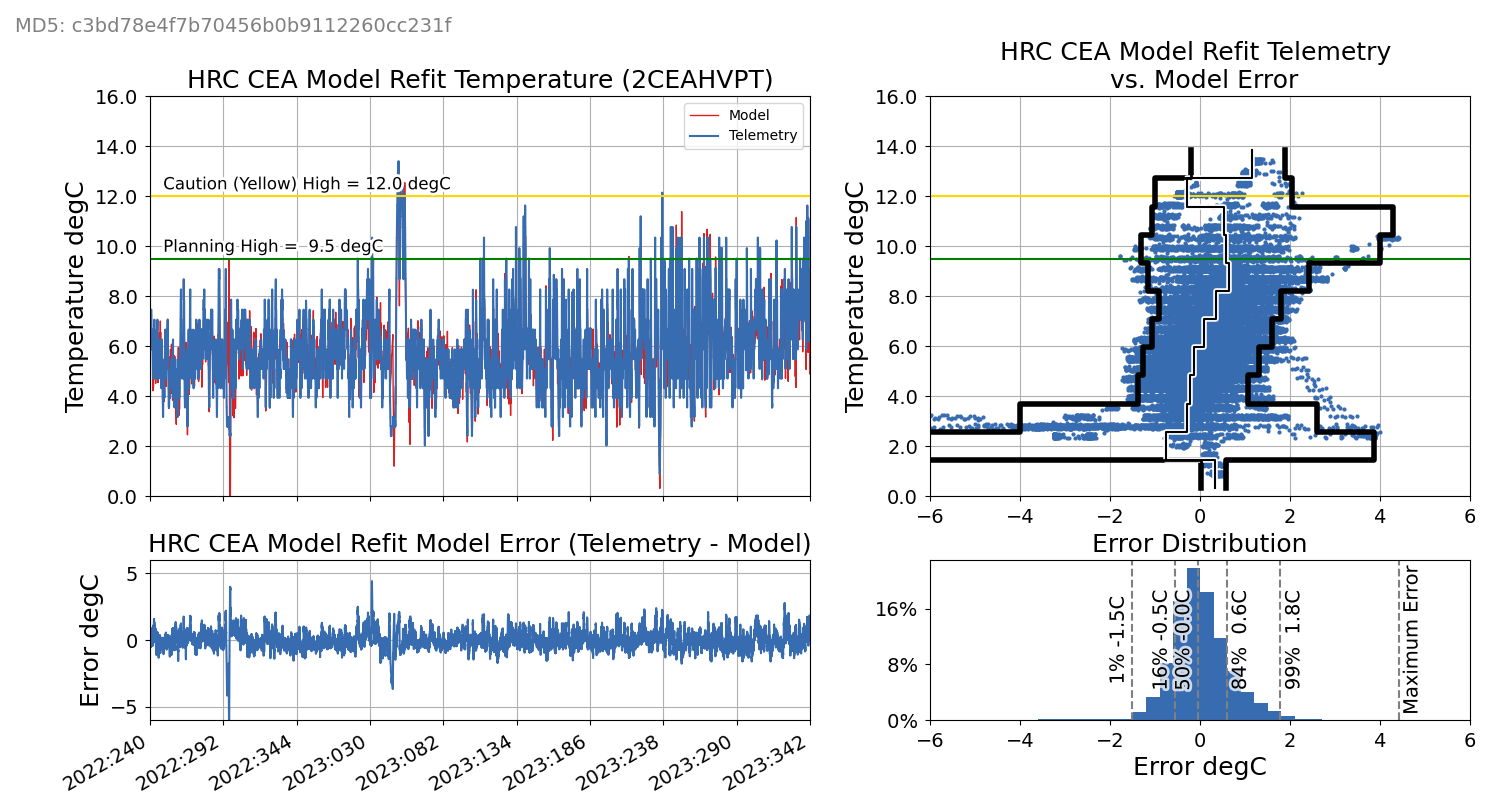

In [11]:
init = {
    'cea0': 10.0, 
    'cea1': 10.0, 
    }
tstart = '2022:240:00:00:00'
tstop = '2023:343:00:00:00'
model_spec_filename = './cea_spec_new_fit_acis_hrc_dp_15dec23.json'
model = make_dashboard(model_spec_filename, 
                       tstart, 
                       tstop, 
                       init=init, 
                       modelname='HRC CEA Model Refit', 
                       msid='2ceahvpt', 
                       bin_size=1, 
                       errorplotlimits=(-6, 6),
                       yplotlimits=(0, 15), savefig=True)

msid = '2ceahvpt'
msiddata = model.get_comp(msid)
prediction = msiddata.mvals.astype(np.float64) # Always do math with 64 bit resolution
times = msiddata.times.astype(np.float64)
telem = msiddata.dvals.astype(np.float64)
error = telem - prediction

# Initialize filtering array to True (keep all points)
# This isn't really necessary here, but I often use this pattern to remove data not relevant to the evaluation of the model
keep = np.zeros(len(telem)) < 1 

<IPython.core.display.Javascript object>


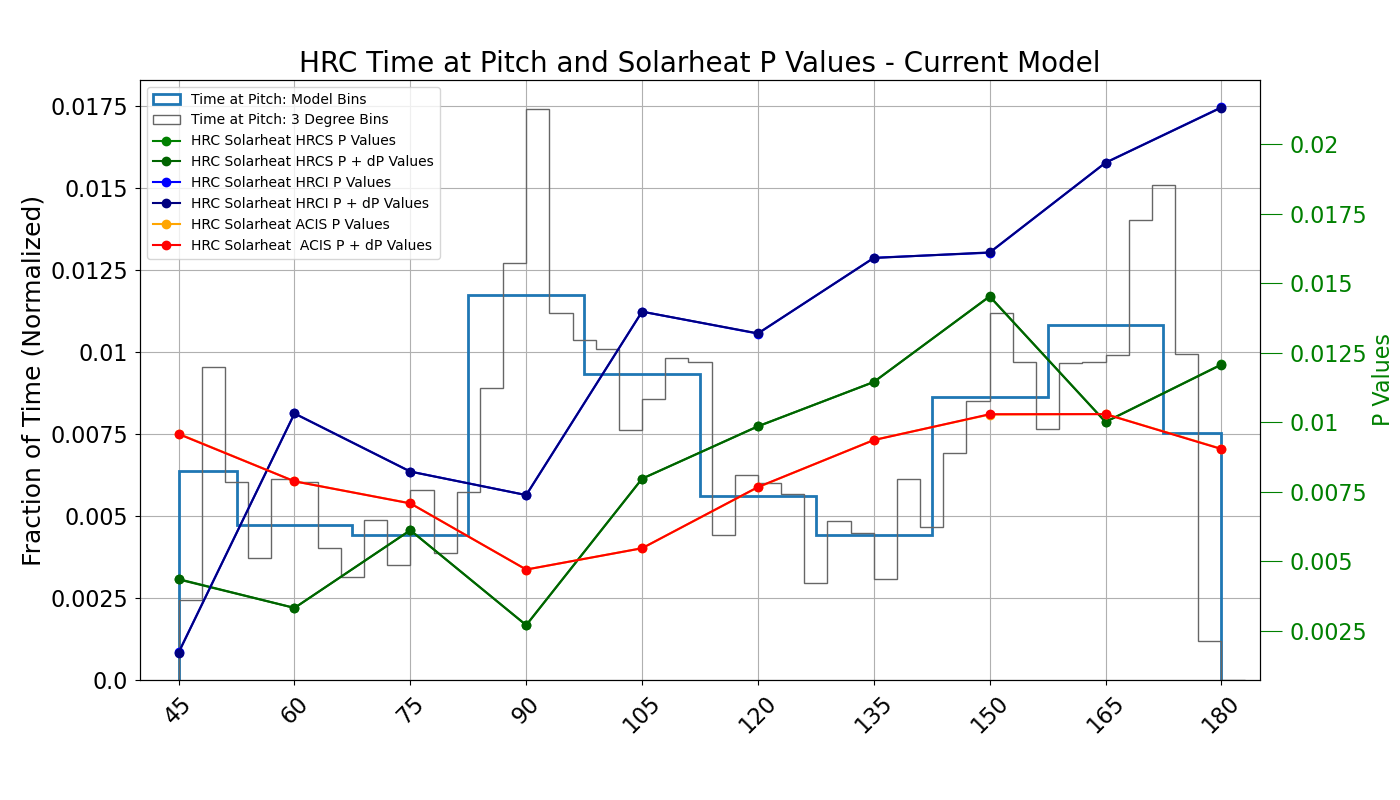

/var/folders/2v/8rh_hsj96d700rq88yst31xw0000gn/T/ipykernel_46187/489807045.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize=16)
/var/folders/2v/8rh_hsj96d700rq88yst31xw0000gn/T/ipykernel_46187/489807045.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax.get_yticks(), fontsize=16)


In [12]:
r = re.compile('solarheat__cea0__P_hrcs_(\d+).*')
p = [(r.findall(d['full_name'])[0], d['val']) for d in model.pars if r.findall(d['full_name'])]
pa_hrcs = np.array(p, dtype=[('pitch', 'i8'), ('val', 'float64')])

r = re.compile('solarheat__cea0__P_hrci_(\d+).*')
p = [(r.findall(d['full_name'])[0], d['val']) for d in model.pars if r.findall(d['full_name'])]
pa_hrci = np.array(p, dtype=[('pitch', 'i8'), ('val', 'float64')])

r = re.compile('solarheat__cea0__P_acis_(\d+).*')
p = [(r.findall(d['full_name'])[0], d['val']) for d in model.pars if r.findall(d['full_name'])]
pa_acis = np.array(p, dtype=[('pitch', 'i8'), ('val', 'float64')])

r = re.compile('solarheat__cea0__dP_(\d+).*')
dp = [(r.findall(d['full_name'])[0], d['val']) for d in model.pars if r.findall(d['full_name'])]
dpa = np.interp(pa_hrcs['pitch'], list(zip(*dp))[0], list(zip(*dp))[1])
dpa = np.array(list(zip(pa_hrcs['pitch'], dpa)), dtype=[('pitch', 'i8'), ('val', 'float64')])

plist = list(dpa['pitch'][:-1] + np.diff(dpa['pitch']) / 2)
plist.insert(0, dpa['pitch'][0])
plist.append(dpa['pitch'][-1])

pitch = fetch.Msid('pitch', tstart, tstop, stat='5min')
pitch = pitch.vals

fig = plt.figure(figsize=(14, 8))
ax = fig.add_axes([0.1, 0.15, 0.8, 0.75])
hist1 = ax.hist(pitch, bins=plist, density=True, linewidth=2, histtype='step', label='Time at Pitch: Model Bins')
hist2 = ax.hist(pitch, bins=np.arange(45, 185, 3), density=True, linewidth=1, color=[.4, .4, .4], histtype='step',
        label='Time at Pitch: 3 Degree Bins')
ax = plt.gca()
ax.set_xticks(dpa['pitch'])
ax.set_xticklabels(ax.get_xticks(), fontsize=16, rotation=45, ha='center')
ax.set_yticklabels(ax.get_yticks(), fontsize=16)
ax.set_title('HRC Time at Pitch and Solarheat P Values - Current Model', fontsize=20)
ax.set_ylabel('Fraction of Time (Normalized)', fontsize=18)
ax.set_xlim(40, 185)
ax.grid(True)

ax2 = ax.twinx()
ln1 = ax2.plot(pa_hrcs['pitch'], pa_hrcs['val'], color='green', marker='o', label='HRC Solarheat HRCS P Values')
ln2 = ax2.plot(pa_hrcs['pitch'], pa_hrcs['val'] + dpa['val'], color='#006400', marker='o', label='HRC Solarheat HRCS P + dP Values')

ln3 = ax2.plot(pa_hrci['pitch'], pa_hrci['val'], color='blue', marker='o', label='HRC Solarheat HRCI P Values')
ln4 = ax2.plot(pa_hrci['pitch'], pa_hrci['val'] + dpa['val'], color='navy', marker='o', label='HRC Solarheat HRCI P + dP Values')

ln5 = ax2.plot(pa_acis['pitch'], pa_acis['val'], color='orange', marker='o', label='HRC Solarheat ACIS P Values')
ln6 = ax2.plot(pa_acis['pitch'], pa_acis['val'] + dpa['val'], color='red', marker='o', label='HRC Solarheat  ACIS P + dP Values')


ax2.set_xlim(40, 185)
ax2.set_ylabel('P Values', color='green', fontsize=16)
ax2.set_yticklabels(ax.get_yticks(), fontsize=16)
ax2.tick_params('y', colors='green', size=16)

lns = hist1[-1] + hist2[-1] + ln1 + ln2 + ln3 + ln4 + ln5 + ln6 
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=2)

plt.show()

fig.savefig('HRC_Time_at_Pitch_with_Solarheat_Model_New.png')